# Deep MNIST Network

Code taken from: https://www.tensorflow.org/get_started/mnist/pros

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
sess = tf.InteractiveSession()

In [5]:
# Data placeholders.
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [6]:
# Initialize weights.
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1) # Introduce slight randomness.
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape) # Introduce slight positive bias to avoid dead neurons.
  return tf.Variable(initial)

In [7]:
# Convolution and max pooling functions.
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [8]:
# Implement convolution layer.
W_conv1 = weight_variable([5, 5, 1, 32]) # 32 features for each 5x5 patch.
b_conv1 = bias_variable([32])

In [9]:
# Reshape image data (number of images, height, width, color channels).
x_image = tf.reshape(x, [-1,28,28,1])

In [10]:
# Convolve and pool.
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [11]:
# 2nd layer with 64 features per patch.
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [12]:
# Dense layer.
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout

In [13]:
# Dropout.
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [14]:
# Output layer.
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [29]:
# Train and evaluate model.
dropout_train_accuracy = []
dropout_test_accuracy = []
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
#train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  if i%50 == 0:
    dropout_train_accuracy.append(accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0}))
    dropout_test_accuracy.append(accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.06
step 1000, training accuracy 0.82
step 2000, training accuracy 0.96
step 3000, training accuracy 0.94
step 4000, training accuracy 0.96
step 5000, training accuracy 0.92
step 6000, training accuracy 0.98
step 7000, training accuracy 1
step 8000, training accuracy 1
step 9000, training accuracy 1
step 10000, training accuracy 0.98
step 11000, training accuracy 1
step 12000, training accuracy 0.96
step 13000, training accuracy 0.92
step 14000, training accuracy 0.98
step 15000, training accuracy 1
step 16000, training accuracy 0.98
step 17000, training accuracy 0.98
step 18000, training accuracy 1
step 19000, training accuracy 0.96
test accuracy 0.9761


# L2

In [16]:
# Output layer.
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

In [30]:
beta = 0.01
    
# Train and evaluate model.
l2_train_accuracy = []
l2_test_accuracy = []
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# Loss function using L2 Regularization
regularizer = tf.reduce_sum(tf.square(W_conv1)) + tf.reduce_sum(tf.square(W_conv2)) + tf.reduce_sum(tf.square(W_fc1))
# Manual calculation of l2 loss. Verified that this works just as well.
#regularizer = tf.reduce_sum(tf.square(W_conv1)) + tf.reduce_sum(tf.square(W_conv2)) + tf.reduce_sum(tf.square(W_fc1))
loss = tf.reduce_mean(cross_entropy + beta * regularizer)

#train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  if i%50 == 0:
    l2_train_accuracy.append(accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0}))
    l2_test_accuracy.append(accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels}))
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels}))

step 0, training accuracy 0.18
step 1000, training accuracy 0.84
step 2000, training accuracy 1
step 3000, training accuracy 0.92
step 4000, training accuracy 0.92
step 5000, training accuracy 0.92
step 6000, training accuracy 1
step 7000, training accuracy 1
step 8000, training accuracy 0.92
step 9000, training accuracy 0.96
step 10000, training accuracy 1
step 11000, training accuracy 1
step 12000, training accuracy 0.98
step 13000, training accuracy 0.98
step 14000, training accuracy 0.96
step 15000, training accuracy 0.98
step 16000, training accuracy 0.96
step 17000, training accuracy 1
step 18000, training accuracy 0.96
step 19000, training accuracy 1
test accuracy 0.9777


# L1

In [31]:
beta = 0.01

# Train and evaluate model.
l1_train_accuracy = []
l1_test_accuracy = []
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# Loss function using L1 Regularization
regularizer = tf.reduce_sum(tf.abs(W_conv1)) + tf.reduce_sum(tf.abs(W_conv1)) + tf.reduce_sum(tf.abs(W_fc1))
loss = tf.reduce_mean(cross_entropy + beta * regularizer)

#train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  if i%50 == 0:
    l1_train_accuracy.append(accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0}))
    l1_test_accuracy.append(accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels}))
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels}))

step 0, training accuracy 0.16
step 1000, training accuracy 0.96
step 2000, training accuracy 0.88
step 3000, training accuracy 0.94
step 4000, training accuracy 0.96
step 5000, training accuracy 0.94
step 6000, training accuracy 0.92
step 7000, training accuracy 0.92
step 8000, training accuracy 0.92
step 9000, training accuracy 0.88
step 10000, training accuracy 0.94
step 11000, training accuracy 0.98
step 12000, training accuracy 0.86
step 13000, training accuracy 0.96
step 14000, training accuracy 0.92
step 15000, training accuracy 0.9
step 16000, training accuracy 0.88
step 17000, training accuracy 0.84
step 18000, training accuracy 0.94
step 19000, training accuracy 0.76
test accuracy 0.8417


# No regularization

In [32]:
# Train and evaluate model.
none_train_accuracy = []
none_test_accuracy = []
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

#train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  if i%50 == 0:
    none_train_accuracy.append(accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0}))
    none_test_accuracy.append(accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels}))
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels}))

step 0, training accuracy 0.18
step 1000, training accuracy 0.82
step 2000, training accuracy 0.98
step 3000, training accuracy 0.9
step 4000, training accuracy 0.96
step 5000, training accuracy 0.98
step 6000, training accuracy 0.94
step 7000, training accuracy 0.94
step 8000, training accuracy 0.94
step 9000, training accuracy 0.98
step 10000, training accuracy 0.94
step 11000, training accuracy 0.92
step 12000, training accuracy 0.96
step 13000, training accuracy 0.94
step 14000, training accuracy 0.98
step 15000, training accuracy 0.96
step 16000, training accuracy 0.96
step 17000, training accuracy 0.8
step 18000, training accuracy 0.86
step 19000, training accuracy 0.9
test accuracy 0.7989


# Compare regularization techniques

In [33]:
accuracy = pd.DataFrame({
    "None (train)": none_train_accuracy,
    "None (test)": none_test_accuracy,
    "L1 (train)": l1_train_accuracy,
    "L1 (test)": l1_test_accuracy,
    "L2 (train)": l2_train_accuracy,
    "L2 (test)": l2_test_accuracy,
    "Dropout (train)": dropout_train_accuracy,
    "Dropout (test)": dropout_test_accuracy,
})

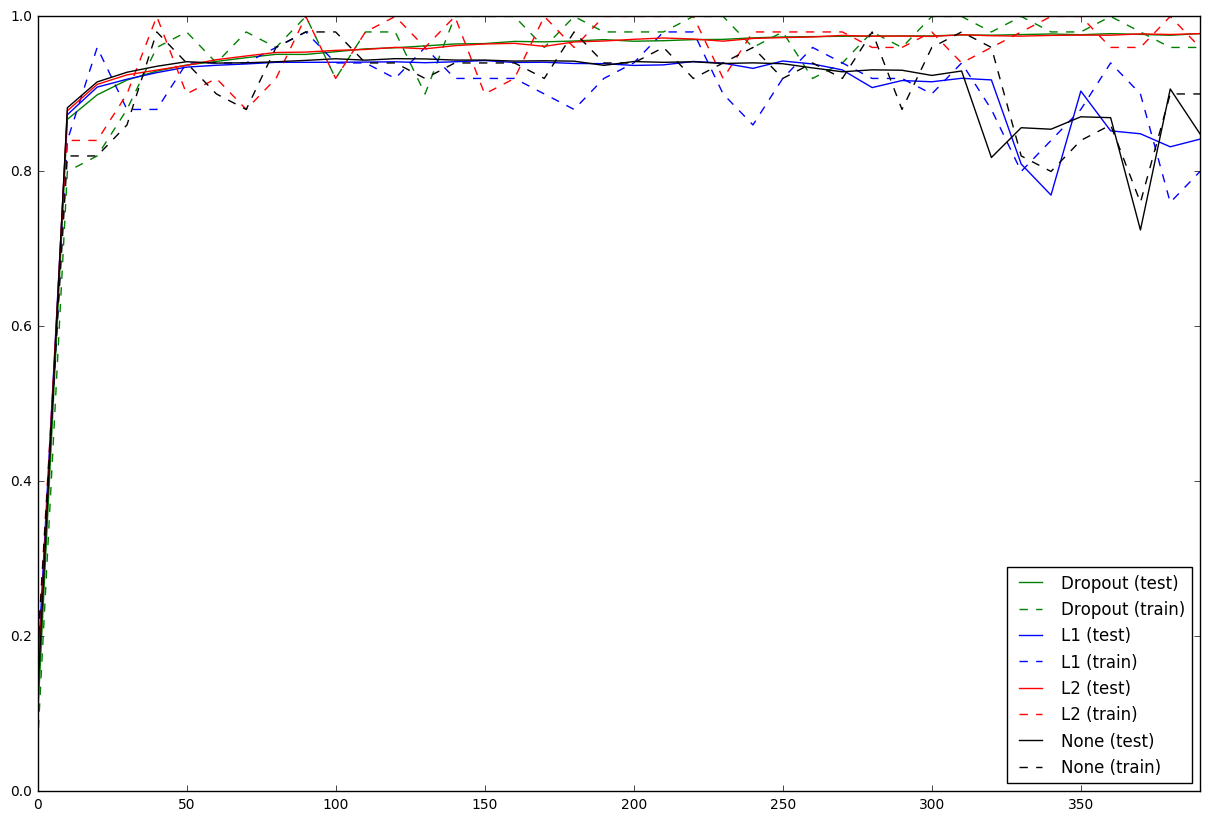

In [34]:
styles = ['g-','g--','b-', 'b--','r-','r--', 'k-','k--']
accuracy.ix[::10,:].plot(style=styles, figsize=(15,10));

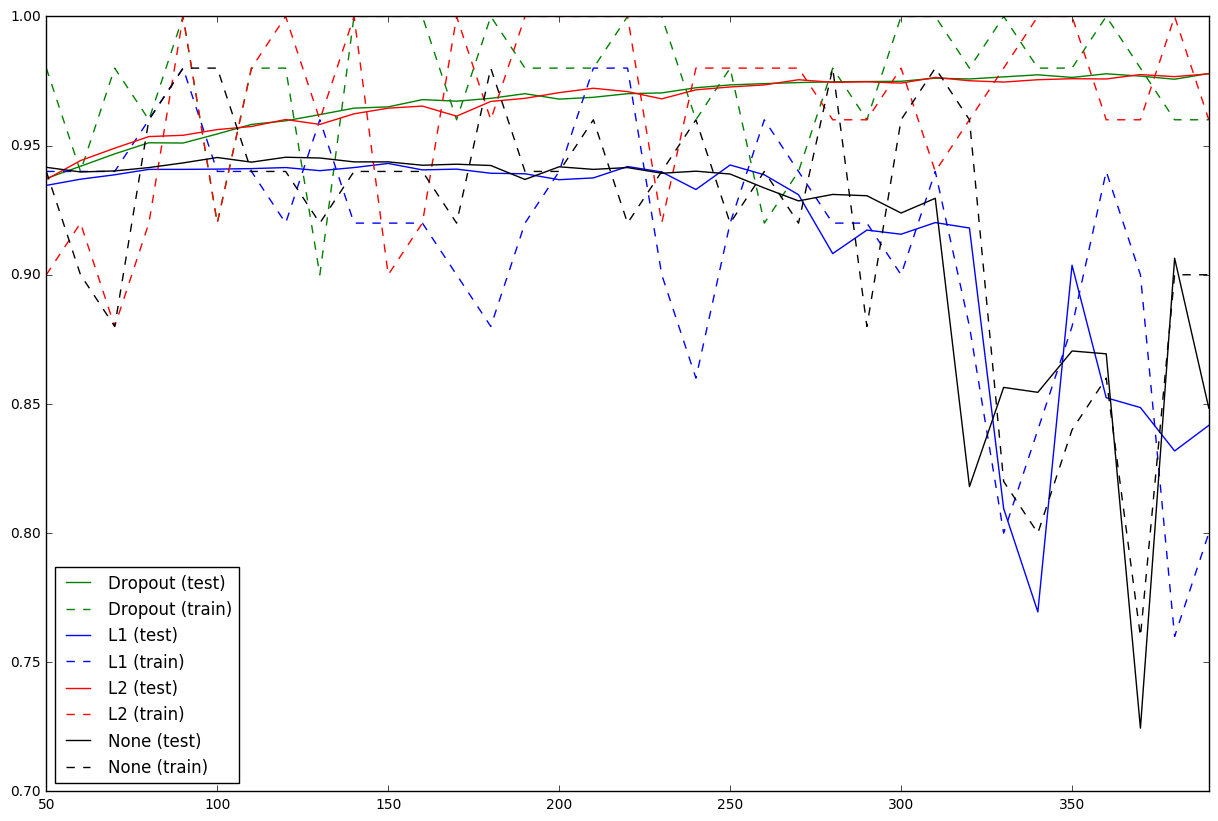

In [35]:
styles = ['g-','g--','b-', 'b--','r-','r--', 'k-','k--']
accuracy.ix[50::10,:].plot(style=styles, figsize=(15,10));